### XGBoost

In [1]:
# lets import all the dependencies
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.model_selection import validation_curve

import xgboost as xgb

from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
# loading the data
df = pd.read_csv("./Data/data.csv",sep=",")
df.drop(['Unnamed: 0'], axis=1, inplace=True) # There were some formatting issues while
                                              # writing the csv

In [3]:
df.head()

,DISTRICT,UPAZILA,STATION_ID,STATION_NAME,DATE,RAIN_FALL(mm),LATITUDE,LONGITUDE,WATER_LEVEL(m)
0,Bandarban,Lama,CL317,Lama,01-jan-2017,0.0,21.81,92.19,6.22
1,Bandarban,Lama,CL317,Lama,02-jan-2017,0.0,21.81,92.19,6.22
2,Bandarban,Lama,CL317,Lama,03-jan-2017,0.0,21.81,92.19,6.22
3,Bandarban,Lama,CL317,Lama,04-jan-2017,0.0,21.81,92.19,6.21
4,Bandarban,Lama,CL317,Lama,05-jan-2017,0.0,21.81,92.19,6.21


Defining our X and y

In [4]:
X = df['RAIN_FALL(mm)'].values.reshape(-1,1) # input feature
y = df['WATER_LEVEL(m)'].values.reshape(-1,1) # target feature

In [5]:
X.shape, y.shape

((1826, 1), (1826, 1))

Making the train test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=17, shuffle=True
)

#### Model Building

Initialize the CV

In [10]:
kfold = KFold(n_splits=5, shuffle=True, random_state=17)

Initialize the XGB with default parameters!

The values of default parameters can be found here: https://xgboost.readthedocs.io/en/stable/parameter.html

Im using Xgboost sklearn wrapper here so that code structure doesnt change much!

In [9]:
xbg_model = xgb.XGBRegressor()

As usual check the CV score first

In [11]:
results = cross_val_score(
    xbg_model,
    X_train,
    y_train,
    cv=kfold,
    scoring='neg_mean_absolute_error'
)
-results.mean()

0.46924084368144003

checking for train-test accuracy

In [13]:
xbg_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [15]:
# accuracy on the train set
knn_pred = xbg_model.predict(X_train)
mean_absolute_error(y_train,knn_pred)

0.35532010421230364

In [16]:
# accuracy on the test set
knn_pred = xbg_model.predict(X_test)
mean_absolute_error(y_test,knn_pred)

0.4707051377530957

Note:
- seems like theres significant overfitting happening here
- Lets plot the learning curve first

#### Learning Curve

In [17]:
# Helper function
alphas = np.logspace(-2, 0, 20)
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )

In [18]:
def plot_learning_curve():
    train_sizes = np.linspace(0.05,1,20)
    N_train, val_train, val_test = learning_curve(
        xbg_model,X,y, train_sizes=train_sizes,cv=kfold,scoring='neg_mean_absolute_error'
    )
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("Negative MAE")
    plt.legend()
    plt.grid(True);

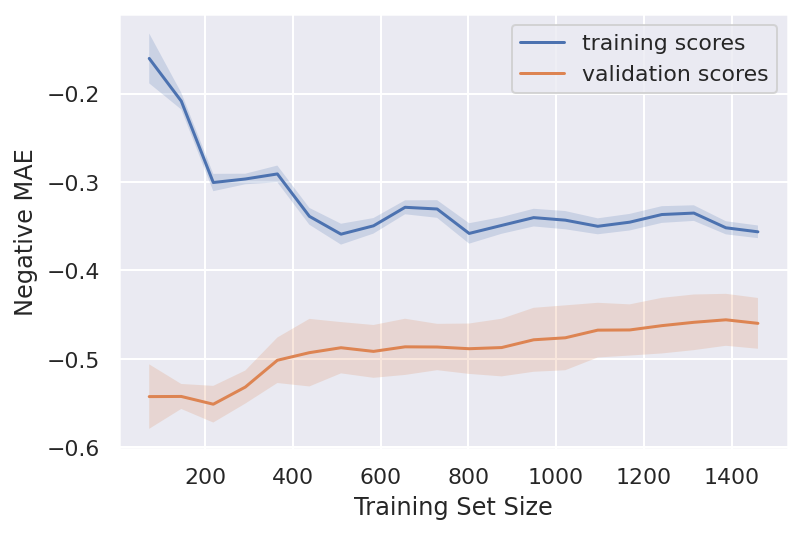

In [19]:
plot_learning_curve()

Note:
- two curves havent converged yet! So theres rooms for improvement!